In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import psutil
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_azure = pd.read_csv("azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [3]:
df_azure['timestamp'] = pd.to_datetime(df_azure['timestamp'])


In [4]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df.set_index('timestamp', inplace=True)

In [5]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

# Lag Features
df['lag1'] = df['avg cpu'].shift(1)
df['lag2'] = df['avg cpu'].shift(2)

# Rolling Window Features
df['rolling_mean_3'] = df['avg cpu'].rolling(window=3).mean()

# Drop the first few rows which might have NaN values due to lagging and rolling
df = df.dropna()

In [6]:
# Splitting data again into train and test
train = df[:int(0.8 * len(df))]
test = df[int(0.8 * len(df)):]

In [7]:
# Preparing training and testing data
X_train = train.drop('avg cpu', axis=1)
y_train = train['avg cpu']
X_test = test.drop('avg cpu', axis=1)
y_test = test['avg cpu']


In [8]:
X_train.shape,y_train.shape

((6910, 7), (6910,))

In [9]:
X_test.shape,y_test.shape

((1728, 7), (1728,))

In [10]:
def evaluate(y_true, y_pred,model,set):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f'{set} mse for {model}: ',mse)
    print(f'{set} rmse for {model}: ',rmse)
    print(f'{set} mae for {model}: ',mae)
    print(f'{set} mape for {model}: ',mape)
    #return mse, rmse, mae, mape

In [11]:
def plot_results(y_train,y_train_pred,y_test,y_test_pred):

    
    plt.figure(figsize=(18, 7))
# Plot for training data
    plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
    plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='green')

    # Plot for testing data
    plt.plot(y_test.index, y_test, label='Actual Test', color='red')
    plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='orange')

    plt.title('Train and Test Predictions')
    plt.xlabel('Time')
    plt.ylabel('Average CPU Usage')
    plt.legend()
    plt.show()

# Benchmark : (mean of train & test set)

In [12]:
y_train.mean()

1200537.2643216155

In [13]:
y_test.mean()

1276133.4170093809

# Random Forest

In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [15]:
print("Train Predictions: ")
evaluate(y_train, y_train_pred_rf,"Random Forest","Train")

print("*"*60)
print("Test Predictions: ")
evaluate(y_test, y_test_pred_rf,"Random Forest","Test")

Train Predictions: 
Train mse for Random Forest:  9270466.977883805
Train rmse for Random Forest:  3044.7441563920943
Train mae for Random Forest:  1396.076975953565
Train mape for Random Forest:  0.0011449053696178945
************************************************************
Test Predictions: 
Test mse for Random Forest:  108408880.79819225
Test rmse for Random Forest:  10411.9585476601
Test mae for Random Forest:  5599.489138632942
Test mape for Random Forest:  0.004164067331015941


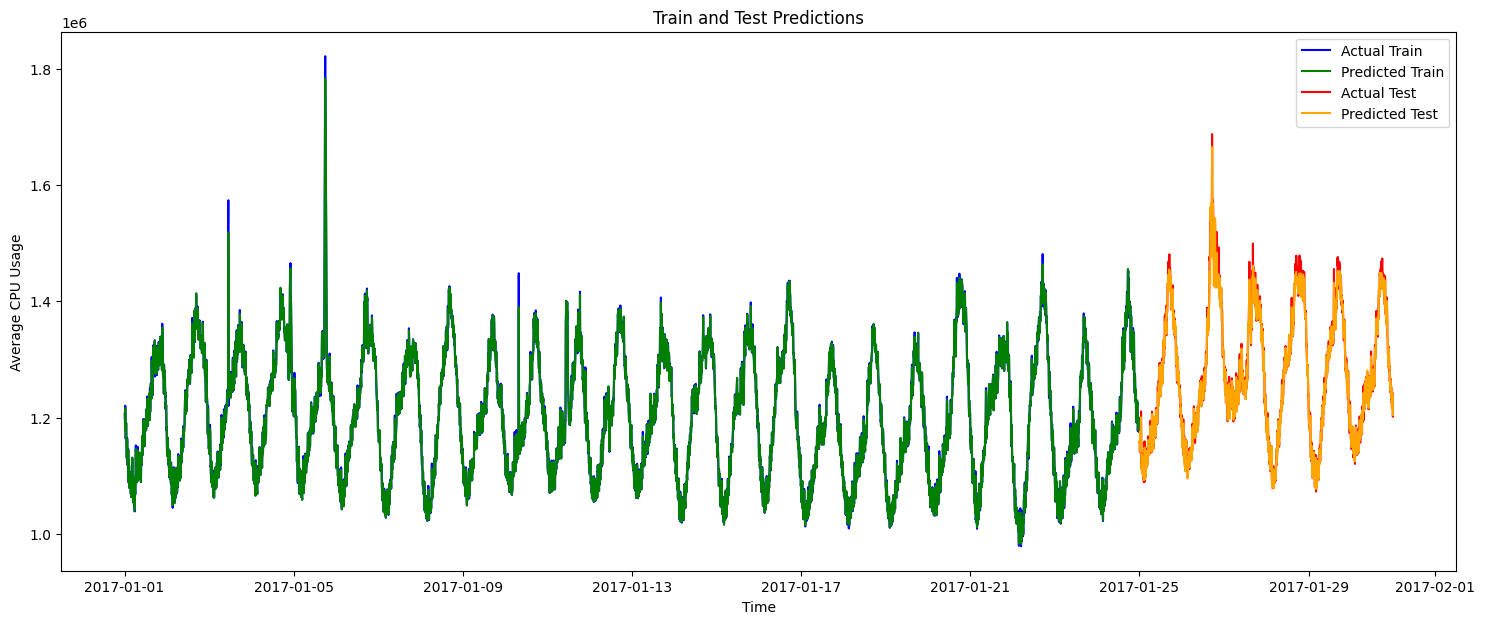

In [16]:
plot_results(y_train,y_train_pred_rf,y_test,y_test_pred_rf)

# XGBoost

In [17]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

print("Train Predictions: ")
evaluate(y_train, y_train_pred_xgb,"XGBoost","Train")

print("*"*60)
print("Test Predictions: ")
evaluate(y_test, y_test_pred_xgb,"XGBoost","Test")

Train Predictions: 
Train mse for XGBoost:  21127121.328806676
Train rmse for XGBoost:  4596.424842070919
Train mae for XGBoost:  1683.504100723185
Train mape for XGBoost:  0.0013809703611948497
************************************************************
Test Predictions: 
Test mse for XGBoost:  404580037.97693485
Test rmse for XGBoost:  20114.175050867358
Test mae for XGBoost:  8181.19945674761
Test mape for XGBoost:  0.005919641403108105


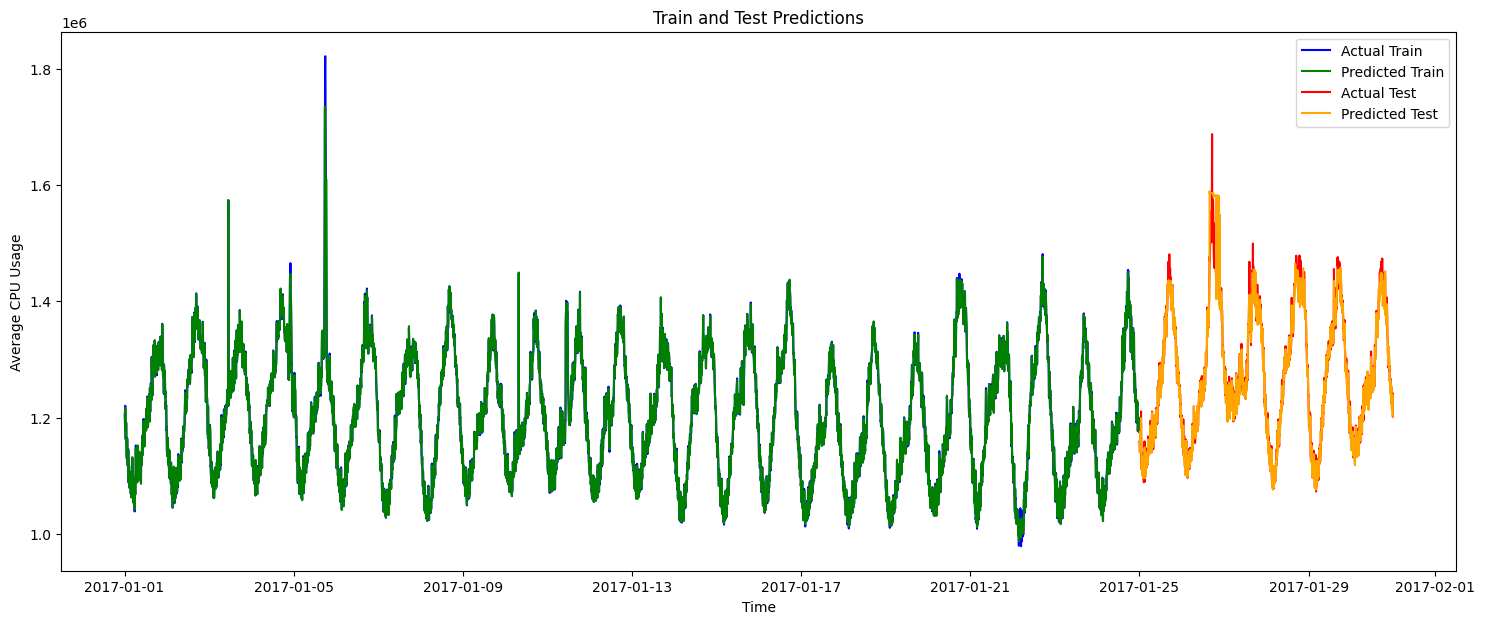

In [18]:
plot_results(y_train,y_train_pred_xgb,y_test,y_test_pred_xgb)

# LGBM

In [19]:
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)
y_train_pred_lgbm = lgbm.predict(X_train)
y_test_pred_lgbm = lgbm.predict(X_test)

print("Train Predictions: ")
evaluate(y_train, y_train_pred_lgbm,"LGBM","Train")

print("*"*60)
print("Test Predictions: ")
evaluate(y_test, y_test_pred_lgbm,"LGBM","Test")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 6910, number of used features: 6
[LightGBM] [Info] Start training from score 1200537.264490
Train Predictions: 
Train mse for LGBM:  64305322.76281263
Train rmse for LGBM:  8019.059967528154
Train mae for LGBM:  3757.3252396192624
Train mape for LGBM:  0.0030837105110310603
************************************************************
Test Predictions: 
Test mse for LGBM:  338399409.7286538
Test rmse for LGBM:  18395.63561632633
Test mae for LGBM:  9525.502633831606
Test mape for LGBM:  0.006999655452411634


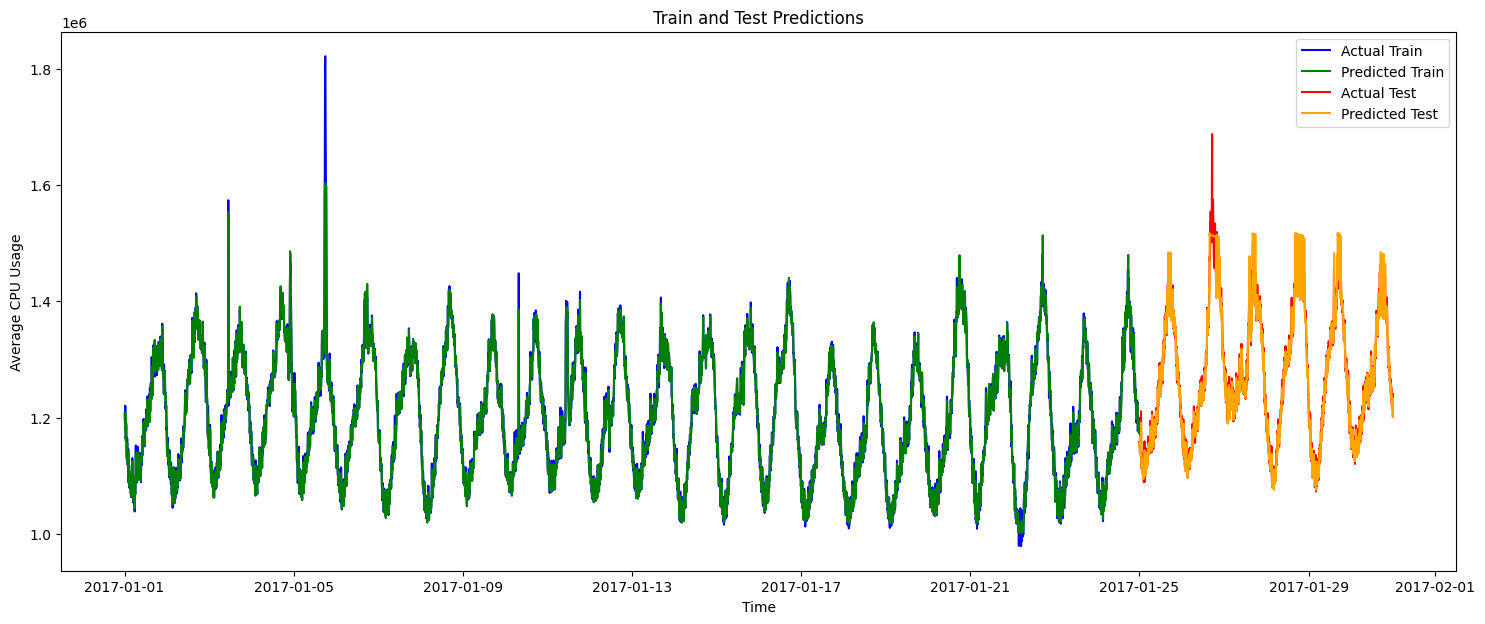

In [20]:
plot_results(y_train,y_train_pred_lgbm,y_test,y_test_pred_lgbm)

# Memory usage

In [2]:
def measure_usage(func):
    def wrapper(*args, **kwargs):
        process = psutil.Process()
        cpu_times_pre = process.cpu_times()
        memory_use_pre = process.memory_info().rss  # rss = Resident Set Size

        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()

        cpu_times_post = process.cpu_times()
        memory_use_post = process.memory_info().rss

        cpu_time_used = (cpu_times_post.user - cpu_times_pre.user) + (cpu_times_post.system - cpu_times_pre.system)
        memory_used = memory_use_post - memory_use_pre
        execution_time = end_time - start_time

        print(f"Function: {func.__name__}")
        print(f"CPU time used: {cpu_time_used:.2f} sec")
        print(f"Memory used: {memory_used / (1024**2):.2f} MB")  # Convert bytes to MB
        print(f"Execution time: {execution_time:.2f} sec")
        return result
    return wrapper

# Ensemble class (Using Random Forest):

In [6]:
class Ensemble_predictions():
    def __init__(self,df,pred_column,date_col = "timestamp"):
        self.df = df
        self.model = "Random Forest"
        print("Columns: ",self.df.columns)
        print("Data shape: ",self.df.shape)
        self.df[date_col] = pd.to_datetime(self.df[date_col], errors='coerce')

        self.df = self.df[[date_col,pred_column]]
        self.df.set_index(date_col, inplace=True)
        print("*"*60)

        self.df['hour'] = self.df.index.hour
        self.df['day_of_week'] = self.df.index.dayofweek
        self.df['day_of_month'] = self.df.index.day
        self.df['month'] = self.df.index.month

        # Lag Features
        self.df['lag1'] = self.df['avg cpu'].shift(1)
        self.df['lag2'] = self.df['avg cpu'].shift(2)

        # Rolling Window Features
        self.df['rolling_mean_3'] = self.df['avg cpu'].rolling(window=3).mean()

        # Drop the first few rows which might have NaN values due to lagging and rolling
        self.df = self.df.dropna()

    def evaluate(self,y_true, y_pred,set):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        print(f'{set} mse for {self.model}: ',mse)
        print(f'{set} rmse for {self.model}: ',rmse)
        print(f'{set} mae for {self.model}: ',mae)
        print(f'{set} mape for {self.model}: ',mape)
    #return mse, rmse, mae, mape

    def plot_results(self,y_train,y_train_pred,y_test,y_test_pred):

        plt.figure(figsize=(18, 7))
        # Plot for training data
        plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
        plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='green')

        # Plot for testing data
        plt.plot(y_test.index, y_test, label='Actual Test', color='red')
        plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='orange')

        plt.title('Train and Test Predictions')
        plt.xlabel('Time')
        plt.ylabel('Average CPU Usage')
        plt.legend()
        plt.show()

    @measure_usage
    def run(self):

        df = self.df
        train = df[:int(0.8 * len(df))]
        test = df[int(0.8 * len(df)):]

        # Preparing training and testing data
        X_train = train.drop('avg cpu', axis=1)
        y_train = train['avg cpu']
        X_test = test.drop('avg cpu', axis=1)
        y_test = test['avg cpu']

        print("X_train shape: ",X_train.shape)
        print("y_train shape: ",y_train.shape)
        print("X_test shape: ",X_test.shape)
        print("y_test shape: ",y_test.shape)
        print("*"*60)


        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_train_pred_rf = rf.predict(X_train)
        y_test_pred_rf = rf.predict(X_test)
        print("Train Predictions: ")
        self.evaluate(y_train, y_train_pred_rf,"Train")

        print("*"*60)
        print("Test Predictions: ")
        self.evaluate(y_test, y_test_pred_rf,"Test")

        self.plot_results(y_train,y_train_pred_rf,y_test,y_test_pred_rf)

In [7]:
df_azure = pd.read_csv("azure.csv")
azure = Ensemble_predictions(df_azure,"avg cpu")
azure.run()

Columns:  Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')
Data shape:  (8640, 4)
************************************************************
X_train shape:  (6910, 7)
y_train shape:  (6910,)
X_test shape:  (1728, 7)
y_test shape:  (1728,)
************************************************************
Train Predictions: 


NameError: name 'evaluate' is not defined